In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from models.nt_classifier import build as build_model
from config import *
from util.plot_utils import obtain_plot, plot_logs, plot_roc_curves
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

In [3]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'binary_cl2') #'binary_cl2')

In [4]:
file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training_nt.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
    
file_test = os.path.join(rna_rna_files_dir, "gene_pairs_test_nt.txt")
with open(file_test, "rb") as fp:   # Unpickling
    gene_pairs_test = pickle.load(fp)
    
file_test_subset = os.path.join(rna_rna_files_dir, "gene_pairs_test_sampled_nt.txt")
with open(file_test_subset, "rb") as fp:   # Unpickling
    gene_pairs_test_subset = pickle.load(fp)

In [9]:
test500 = pd.read_csv(os.path.join(metadata_dir, 'test500.csv'))

In [10]:
res = pd.read_csv(os.path.join(checkpoint_dir, 'test_results500_finetuning.csv'))

print(classification_report(res.ground_truth, res.prediction))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70     30829
           1       0.41      0.49      0.45     14569

    accuracy                           0.61     45398
   macro avg       0.57      0.58      0.57     45398
weighted avg       0.63      0.61      0.62     45398



# PLOTS

### Log plots

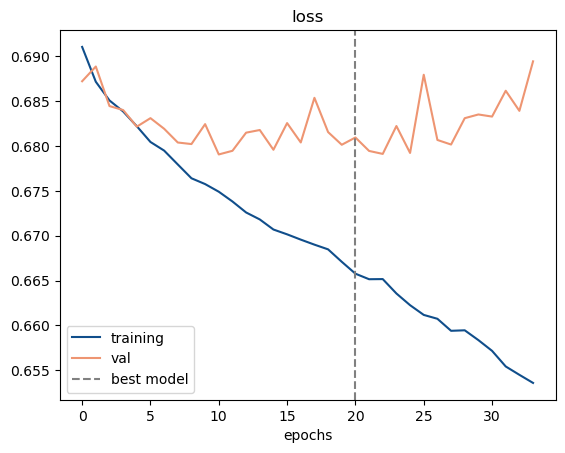

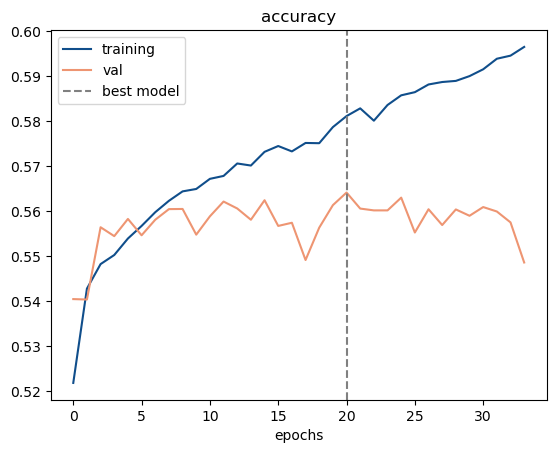

In [11]:
log = pd.read_json(Path(os.path.join(checkpoint_dir, 'log.txt')), lines=True)
best_model = np.argmax(log.test_accuracy)
for metric in ['loss', 'accuracy']:
    plot_logs(log, metric, best_model = best_model)

## Metrics

In [12]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

0    28163
1    17235
Name: prediction, dtype: int64


0    30829
1    14569
Name: ground_truth, dtype: int64


In [13]:
n_conf = 10

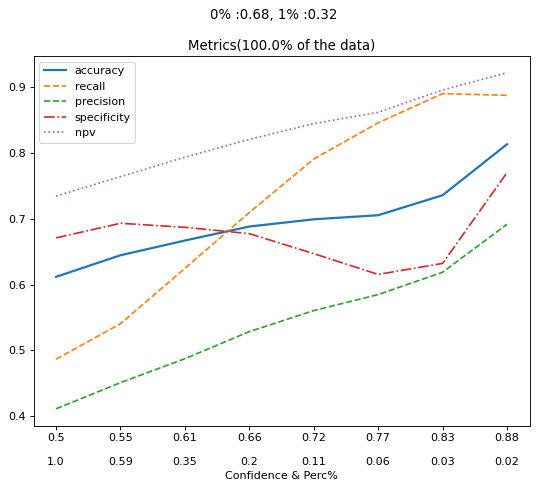

In [14]:
obtain_plot(res, n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)

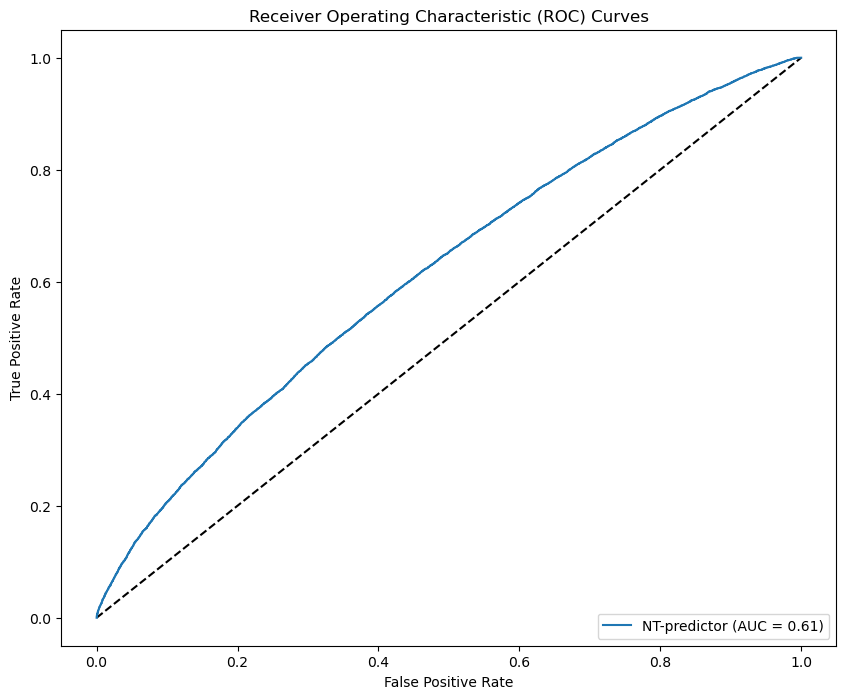

In [15]:
plot_roc_curves([{'prob': res.probability, 'model_name': 'NT-predictor'}], res.ground_truth)

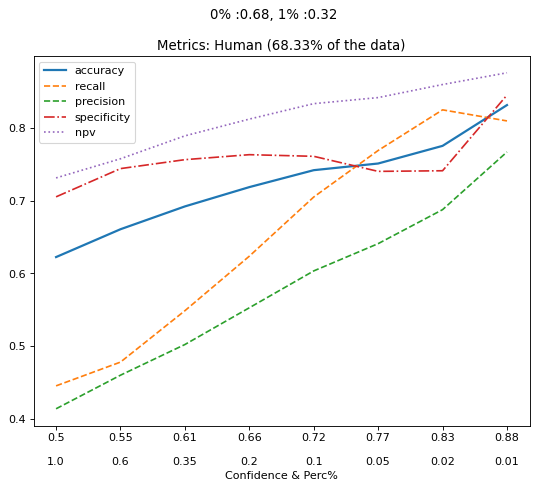

In [16]:
human = res[(res.specie == 'human')]
obtain_plot(human, n_original_df = res.shape[0], title = f'Metrics: Human ', n_conf = n_conf)

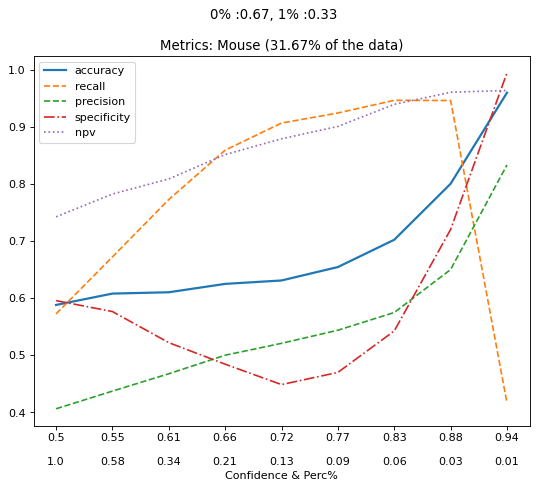

In [17]:
mouse = res[(res.specie == 'mouse')]
obtain_plot(mouse, n_original_df = res.shape[0], title = f'Metrics: Mouse ', n_conf = n_conf)

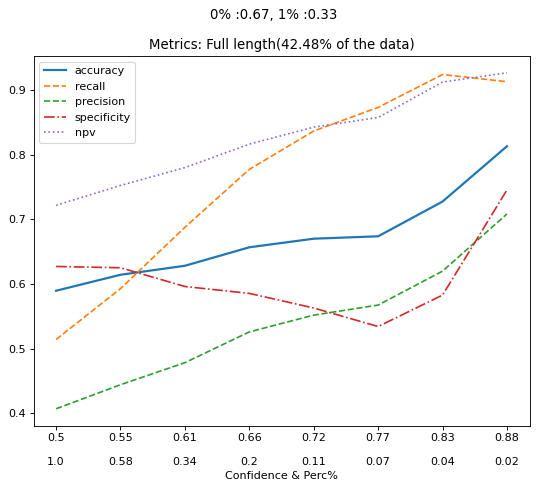

In [18]:
full_length = res[(res.original_length1 <= MAX_RNA_SIZE)&(res.original_length2 <= MAX_RNA_SIZE)]
obtain_plot(full_length, n_original_df = res.shape[0], title = f'Metrics: Full length', n_conf = 10)

In [19]:
confidence_level = 0.65
high_conf_fl = full_length[(full_length.probability>confidence_level)|(full_length.probability<(1-confidence_level))]

In [20]:
(high_conf_fl.ground_truth == high_conf_fl.prediction).sum() / high_conf_fl.shape[0]

0.6473528743467394

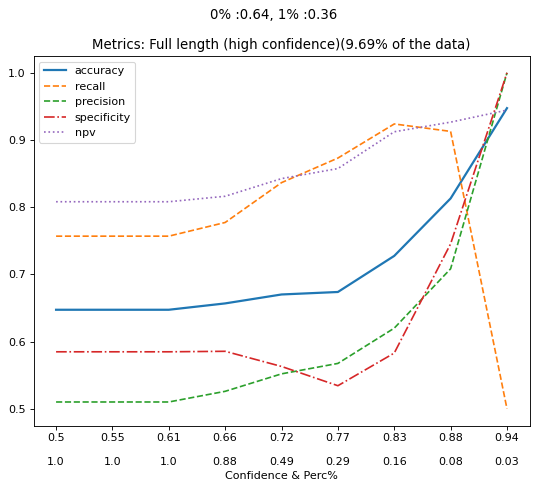

In [21]:
confidence_level = 0.65
high_conf_fl = full_length[(full_length.probability>confidence_level)|(full_length.probability<(1-confidence_level))]
obtain_plot(high_conf_fl, n_original_df = res.shape[0], title = f'Metrics: Full length (high confidence)', n_conf = n_conf)

In [18]:
# big_area_size = res.sampled_area.quantile(0.9)
# big_area_size = 5000**2
# big_area = res[res['sampled_area'] > big_area_size]

# obtain_plot(big_area, n_original_df = res.shape[0], title = f'Metrics: Big area', n_conf = n_conf)

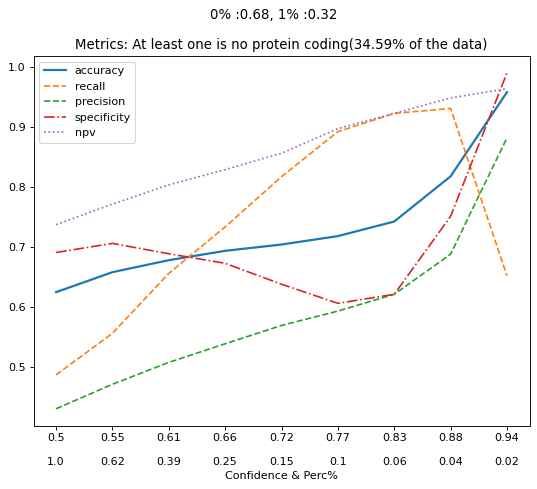

In [22]:
no_pc = res[(res['gene1_pc'] == False)|(res['gene2_pc'] == False)]

obtain_plot(no_pc, n_original_df = res.shape[0], title = f'Metrics: At least one is no protein coding', n_conf = n_conf)

In [23]:
test = pd.read_csv(os.path.join(metadata_dir, f'test_sampled.csv'))
print(test.interacting.value_counts())
test = test[['id_gene1_sample', 'id_gene2_sample']]

False    14569
True     14569
Name: interacting, dtype: int64


In [24]:
res1 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene1_sample', 'id_gene2_sample'])
res2 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene2_sample', 'id_gene1_sample'])
easypos_smartneg = pd.concat([res1, res2], axis = 0)
easypos_smartneg.ground_truth.value_counts()

1    14577
0    14570
Name: ground_truth, dtype: int64

In [22]:
# subset_test_nt_sampled = os.path.join(rna_rna_files_dir, f"gene_pairs_test_sampled_nt.txt")
# with open(subset_test_nt_sampled, "rb") as fp:  # Unpickling
#     subset_test_nt_sampled = pickle.load(fp)
    
# easypos_smartneg = res[res.id_sample.isin(subset_test_nt_sampled)]

0.5792019761896593


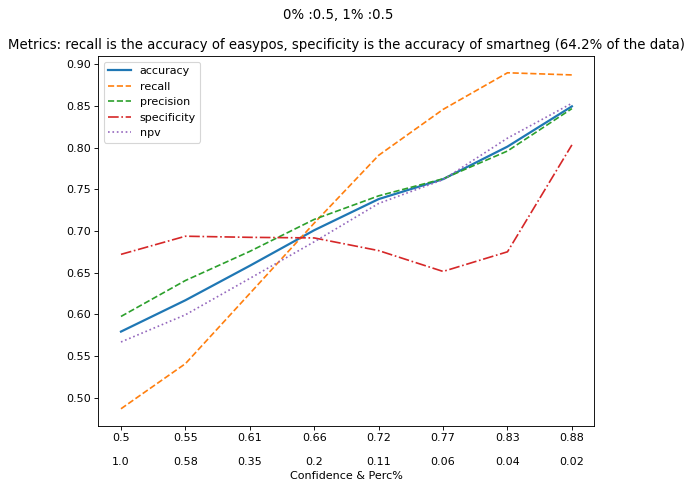

In [25]:
# vc = easypos_smartneg.ground_truth.value_counts()
# assert vc.loc[1] > vc.loc[0]
# n_to_exclude = vc.loc[1] - vc.loc[0]
# easypos_gt = easypos_smartneg[easypos_smartneg.ground_truth==1]
# id_to_exclude = list(easypos_gt.sample(frac = 1).head(n_to_exclude).id_sample)
# easypos_smartneg_sampled = easypos_smartneg[~easypos_smartneg.id_sample.isin(id_to_exclude)]

easypos_smartneg_sampled = easypos_smartneg
print((easypos_smartneg_sampled.prediction == easypos_smartneg_sampled.ground_truth).sum()/easypos_smartneg_sampled.shape[0])
obtain_plot(easypos_smartneg_sampled, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg ', n_conf = n_conf)

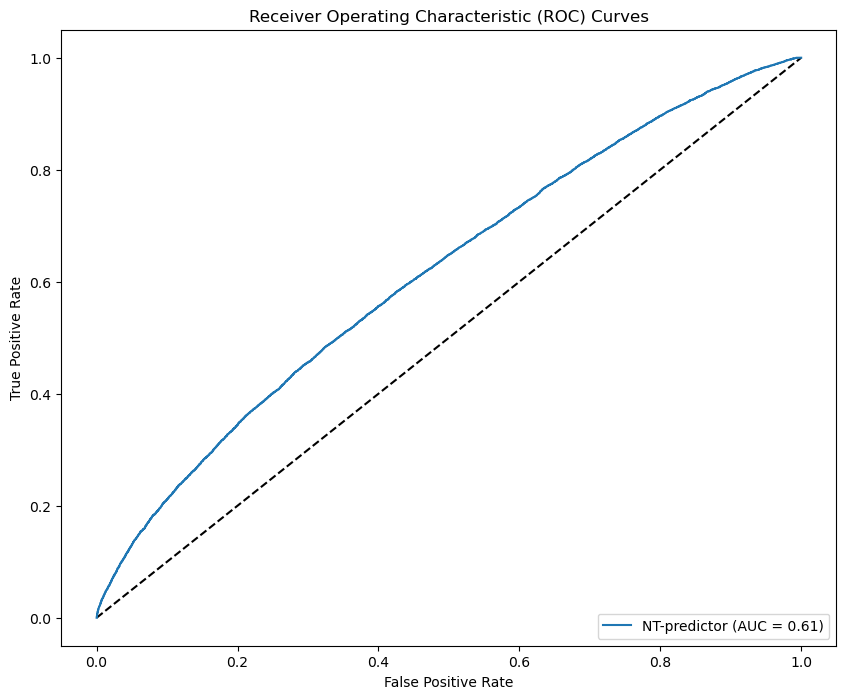

In [26]:
plot_roc_curves([{'prob': easypos_smartneg_sampled.probability, 'model_name': 'NT-predictor'}], easypos_smartneg_sampled.ground_truth)

0.7702991452991453


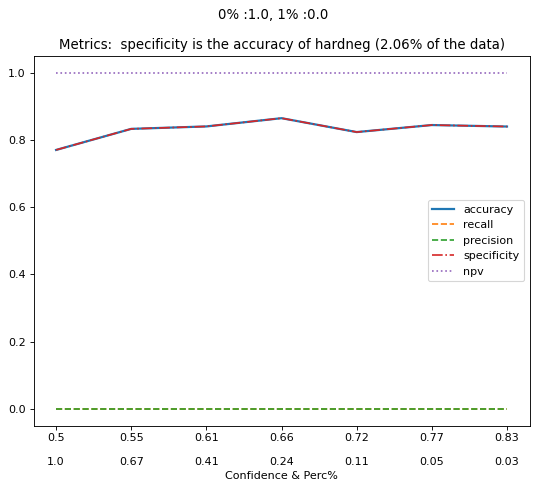

In [27]:
hn = res[(res.policy == 'hardneg')]
print(hn[hn.ground_truth == hn.prediction].shape[0]/hn.shape[0])

obtain_plot(hn, n_original_df = res.shape[0], title = f'Metrics:  specificity is the accuracy of hardneg ', n_conf = n_conf)

0.8099467140319716


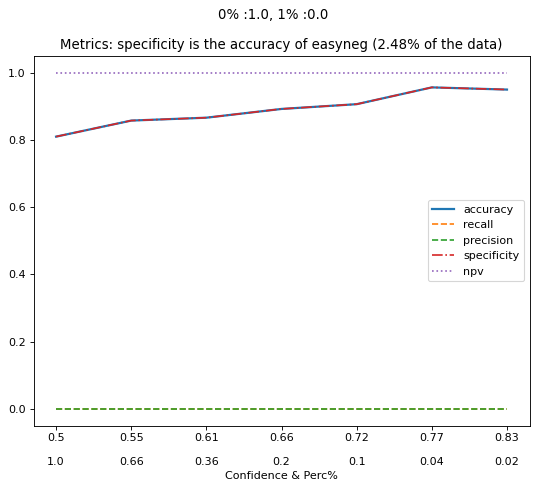

In [28]:
easy = res[(res.policy == 'easyneg')]
print(easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0])

obtain_plot(easy, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg ', n_conf = n_conf)

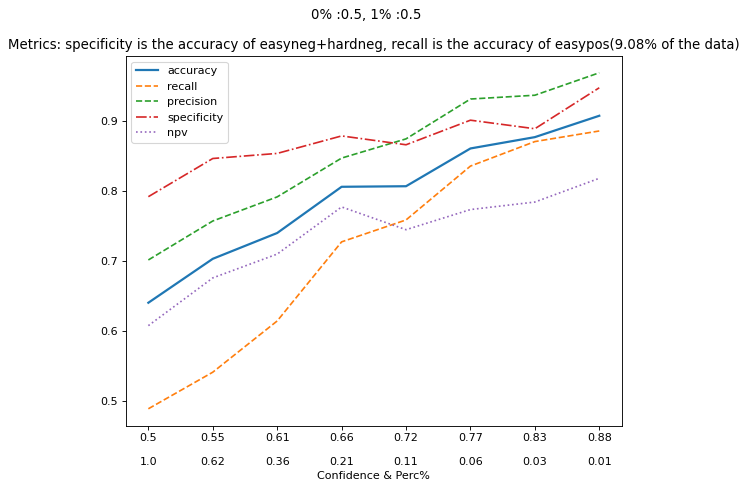

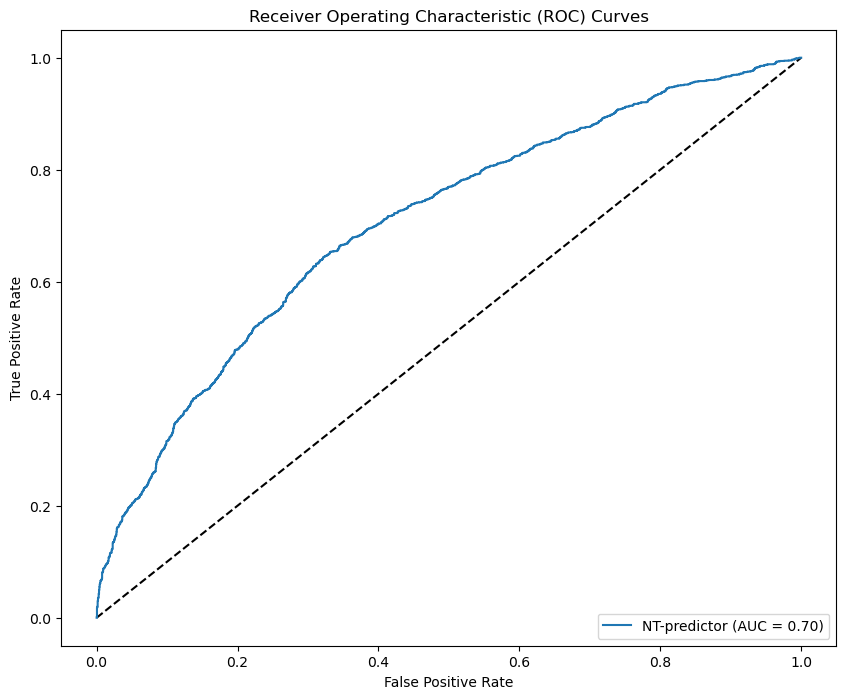

In [29]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

vc = ephnen.ground_truth.value_counts()
assert vc.loc[1] > vc.loc[0]
n_to_exclude = vc.loc[1] - vc.loc[0]
ephnen_gt = ephnen[ephnen.ground_truth==1]
id_to_exclude = list(ephnen_gt.sample(frac = 1).head(n_to_exclude).id_sample)
ephnen_sampled = ephnen[~ephnen.id_sample.isin(id_to_exclude)]

obtain_plot(ephnen_sampled, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg+hardneg, recall is the accuracy of easypos', n_conf = n_conf)
plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT-predictor'}], ephnen_sampled.ground_truth)

/tmp/ipykernel_561004/84461656.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))


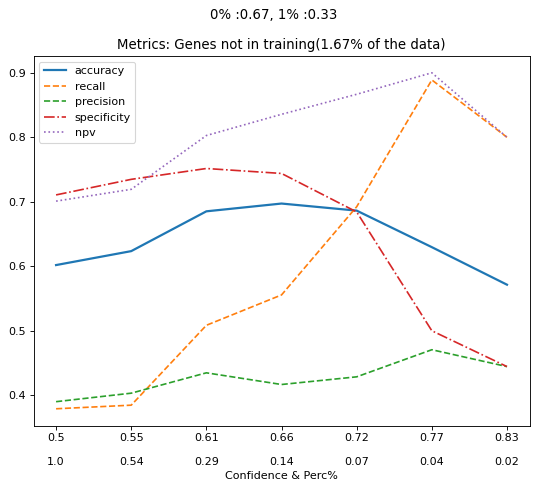

In [30]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

not_in_train = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]

obtain_plot(not_in_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training', n_conf = n_conf)

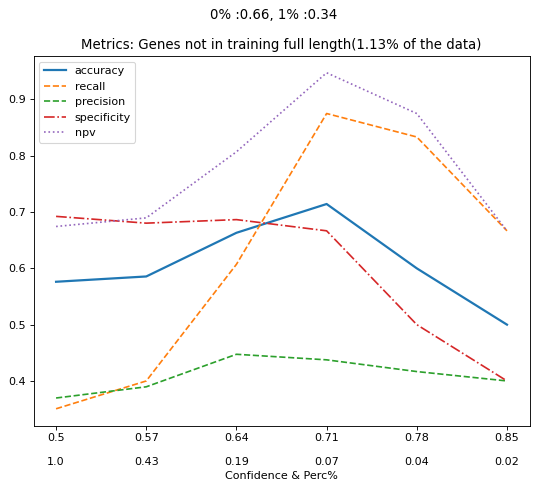

In [31]:
not_in_train_fl = not_in_train[(not_in_train.original_length1 <= MAX_RNA_SIZE)&(not_in_train.original_length2 <= MAX_RNA_SIZE)]
not_in_train_fl = not_in_train_fl[(not_in_train_fl.policy == 'easypos')|(not_in_train_fl.policy == 'smartneg')]
obtain_plot(not_in_train_fl, n_original_df = res.shape[0], title = f'Metrics: Genes not in training full length', n_conf = 8)

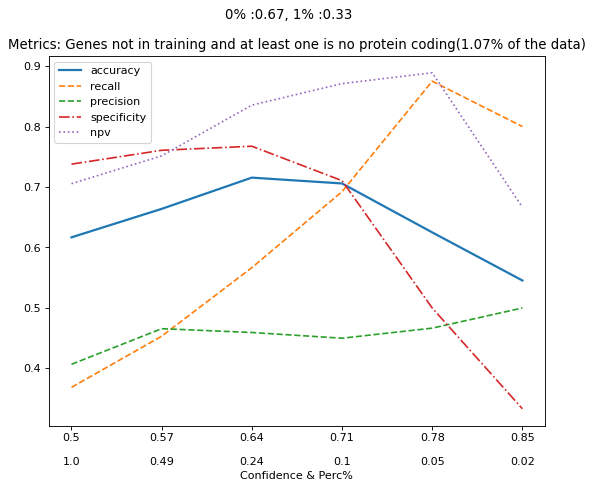

In [32]:
no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]

obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding', n_conf = 8)

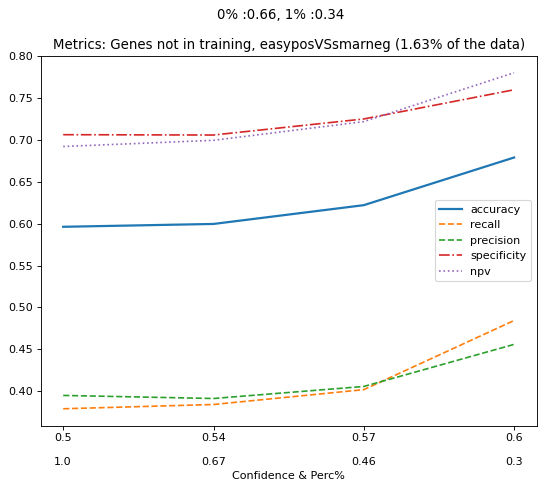

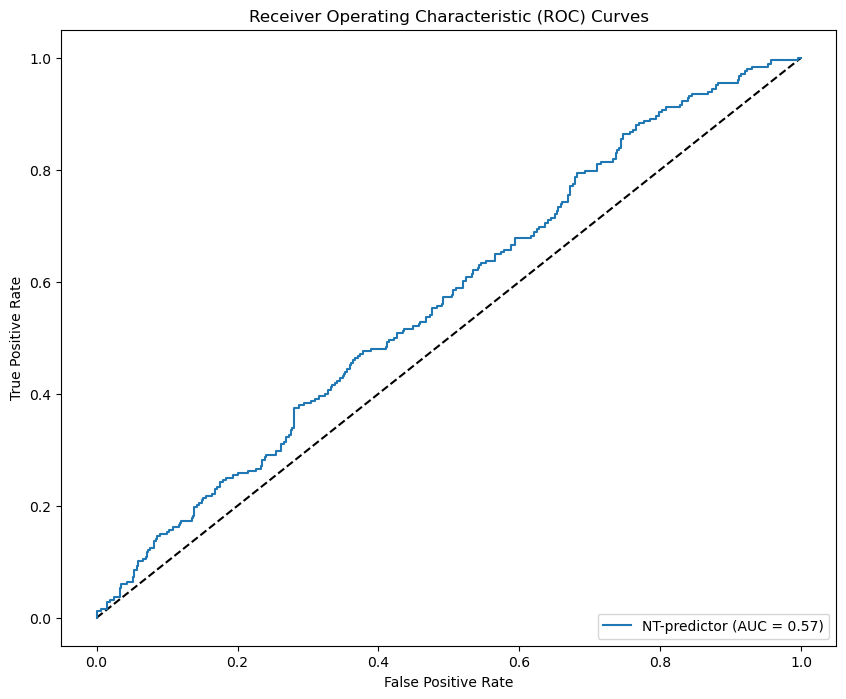

In [33]:
not_in_train_epsn = not_in_train[(not_in_train.policy == 'easypos')|(not_in_train.policy == 'smartneg')]
obtain_plot(not_in_train_epsn, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, easyposVSsmarneg ', n_conf = 15, excluding_treshold = 0.2)
plot_roc_curves([{'prob': not_in_train_epsn.probability, 'model_name': 'NT-predictor'}], not_in_train_epsn.ground_truth)

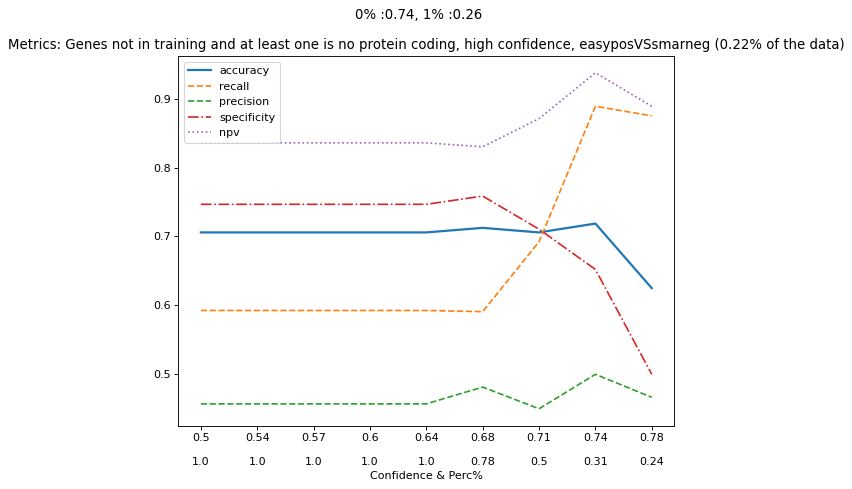

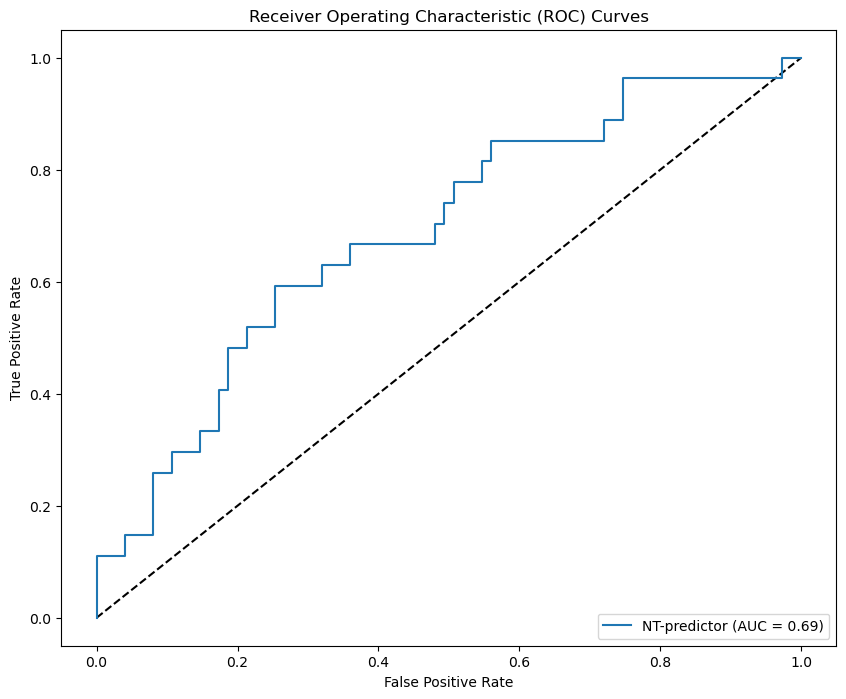

In [34]:
confidence_level = 0.65

no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.probability>confidence_level)|(no_pc_no_train.probability<(1-confidence_level))]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.policy == 'easypos')|(no_pc_no_train.policy == 'smartneg')]
obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding, high confidence, easyposVSsmarneg ', n_conf = 15, excluding_treshold = 0.2)
plot_roc_curves([{'prob': no_pc_no_train.probability, 'model_name': 'NT-predictor'}], no_pc_no_train.ground_truth)

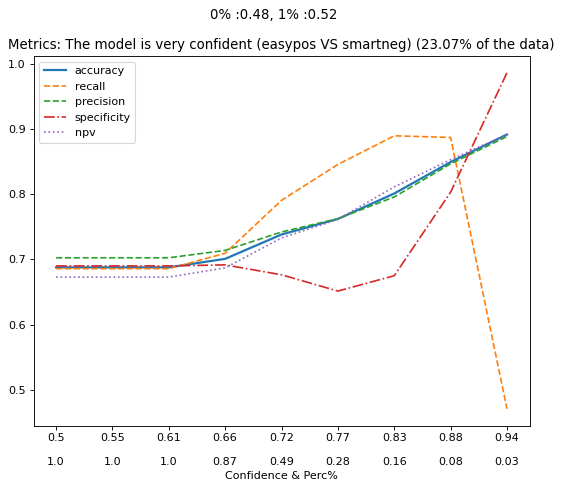

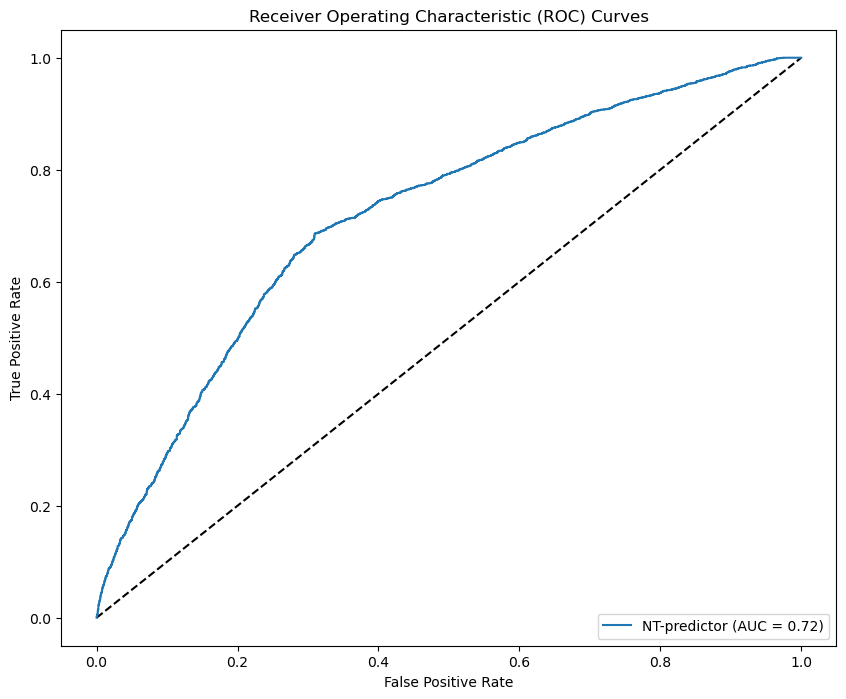

In [35]:
confidence_level = 0.65
high_prob_pairs = easypos_smartneg[(easypos_smartneg.probability>confidence_level)|(easypos_smartneg.probability<(1-confidence_level))]

obtain_plot(high_prob_pairs, n_original_df = easypos_smartneg.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) ', n_conf = n_conf)
plot_roc_curves([{'prob': high_prob_pairs.probability, 'model_name': 'NT-predictor'}], high_prob_pairs.ground_truth)

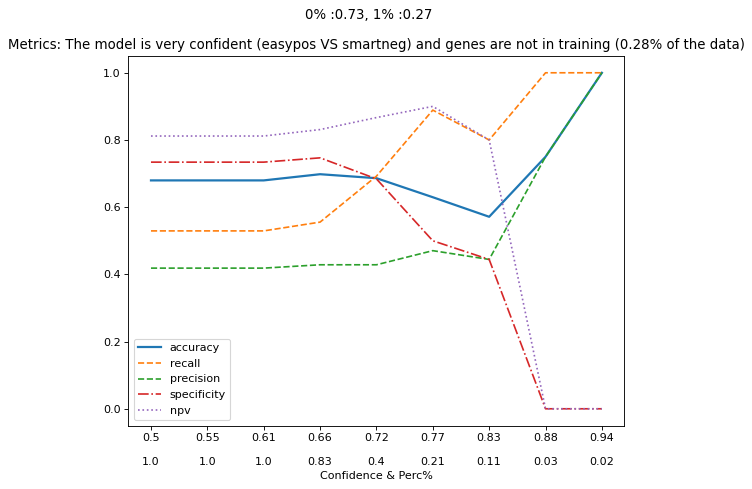

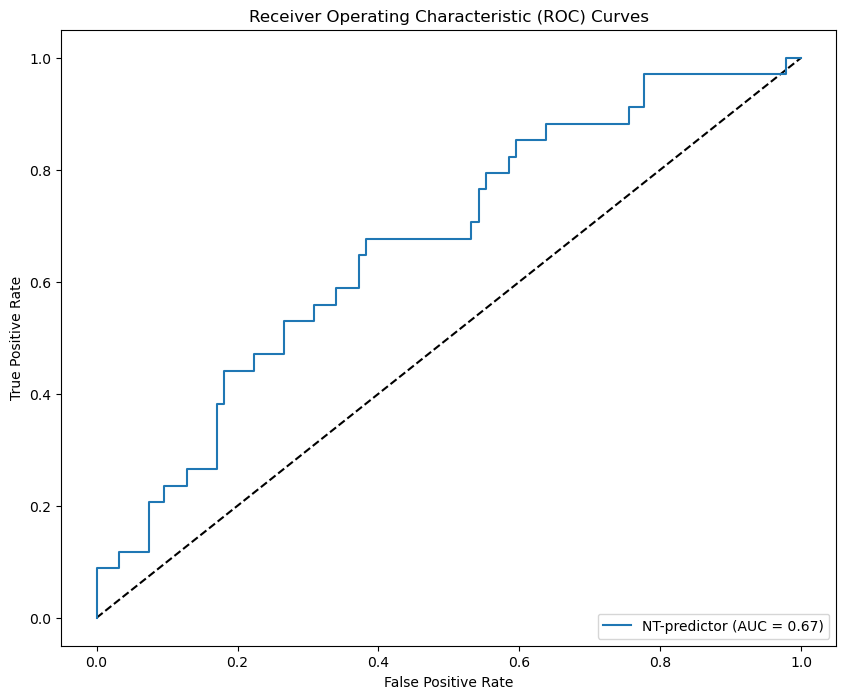

In [36]:
confidence_level = 0.65
high_prob_pairs = not_in_train[(not_in_train.probability>confidence_level)|(not_in_train.probability<(1-confidence_level))]
high_prob_pairs = high_prob_pairs[(high_prob_pairs.policy == 'easypos')|(high_prob_pairs.policy == 'smartneg')]

obtain_plot(high_prob_pairs, n_original_df = res.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) and genes are not in training ', n_conf = n_conf)
plot_roc_curves([{'prob': high_prob_pairs.probability, 'model_name': 'NT-predictor'}], high_prob_pairs.ground_truth)

# Compare with INTARNA

In [7]:
intarna = pd.read_csv(os.path.join(intarna_dir, 'test500', 'test.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)

# #merge with id of df_nt
# df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
# df_nt = df_nt[['couples', 'interacting']]
# df_nt['interacting'] = df_nt['interacting'].astype(int)

In [8]:
res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

In [9]:
intarna.shape[0]

45398

In [10]:
res.shape[0]

45398

In [11]:
auc_nt = []
auc_intarna = []

for i in range(500):
    # undersample 0 class
    res0 = res[res.ground_truth == 0]
    res1 = res[res.ground_truth == 1]
    balanced = pd.concat([res0.sample(res1.shape[0]), res1], axis = 0)

    fpr, tpr, _ = roc_curve(balanced.ground_truth, balanced.probability)
    roc_auc = auc(fpr, tpr)
    auc_nt.append(roc_auc)
    
    fpr, tpr, _ = roc_curve(abs(1 - balanced.ground_truth), balanced.E_norm)
    roc_auc = auc(fpr, tpr)
    auc_intarna.append(roc_auc)

In [12]:
print(np.mean(auc_nt), 
      np.mean(auc_intarna)
     )

0.6227113086037745 0.5367370178706246


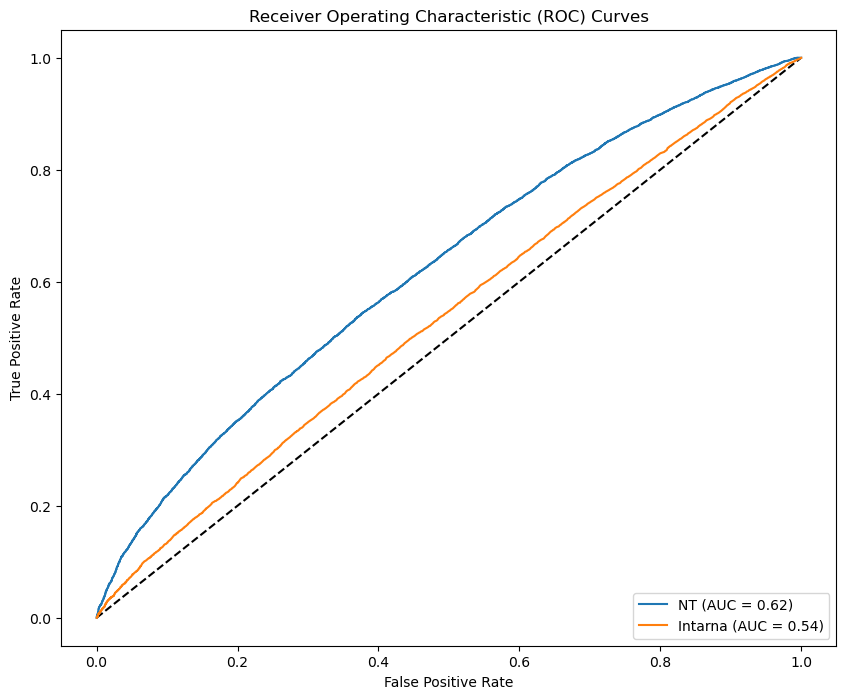

In [13]:
plot_roc_curves([{'prob': balanced.probability, 'model_name': 'NT'},
                 {'prob': abs(balanced.E_norm), 'model_name': 'Intarna'}
                ], balanced.ground_truth)

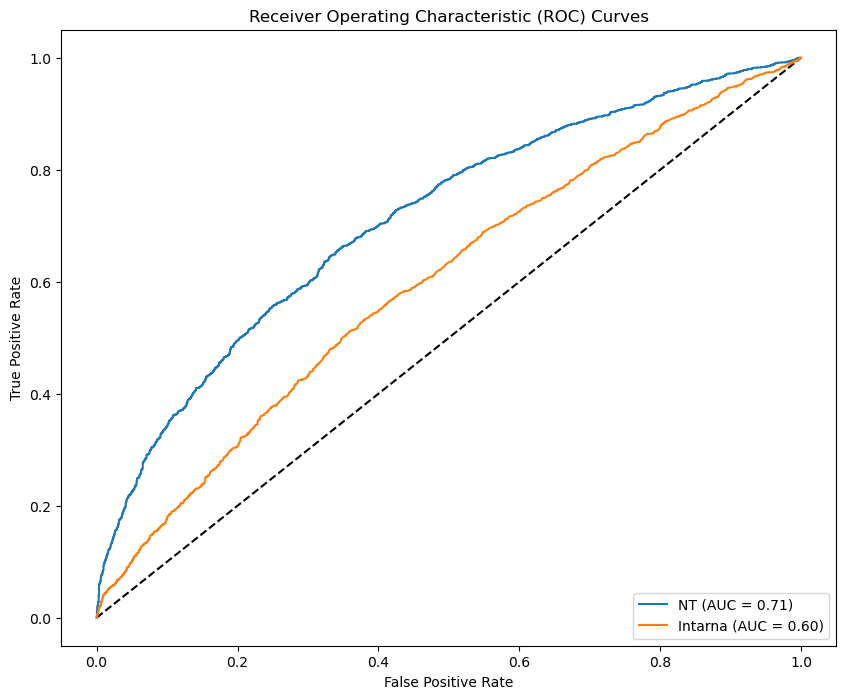

In [14]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

vc = ephnen.ground_truth.value_counts()
assert vc.loc[1] > vc.loc[0]
n_to_exclude = vc.loc[1] - vc.loc[0]
ephnen_gt = ephnen[ephnen.ground_truth==1]
id_to_exclude = list(ephnen_gt.sample(frac = 1).head(n_to_exclude).id_sample)
ephnen_sampled = ephnen[~ephnen.id_sample.isin(id_to_exclude)]

plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT'},
                 {'prob': abs(ephnen_sampled.E_norm), 'model_name': 'Intarna'}
                ], ephnen_sampled.ground_truth)

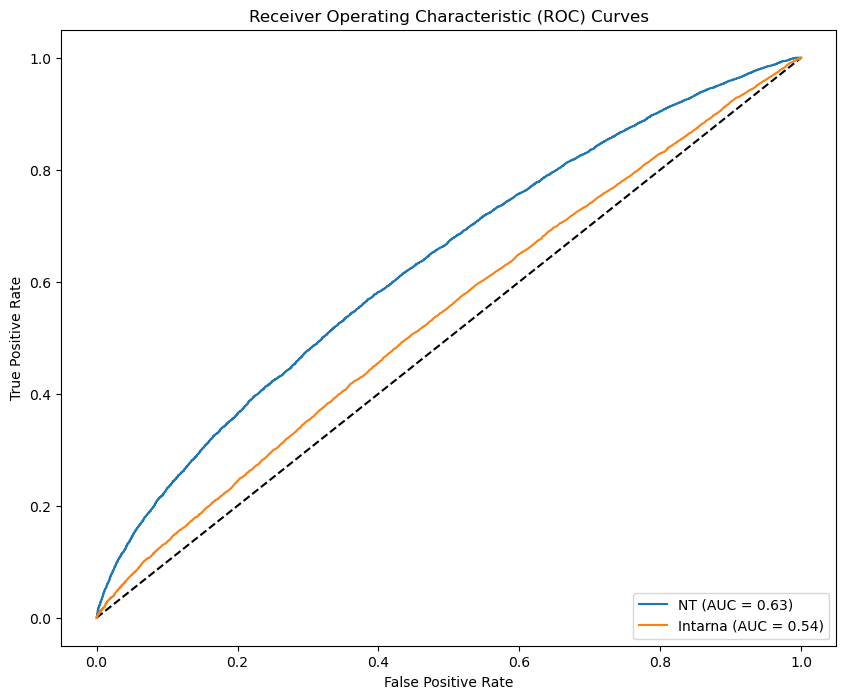

In [15]:
test = pd.read_csv(os.path.join(metadata_dir, f'test_sampled.csv'))
test = test[['id_gene1_sample', 'id_gene2_sample']]

res1 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene1_sample', 'id_gene2_sample'])
res2 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene2_sample', 'id_gene1_sample'])
easypos_smartneg = pd.concat([res1, res2], axis = 0)
easypos_smartneg.ground_truth.value_counts()

plot_roc_curves([{'prob': easypos_smartneg.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg.E_norm), 'model_name': 'Intarna'}
                ], easypos_smartneg.ground_truth)

#### Compare AUC based on confidence

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


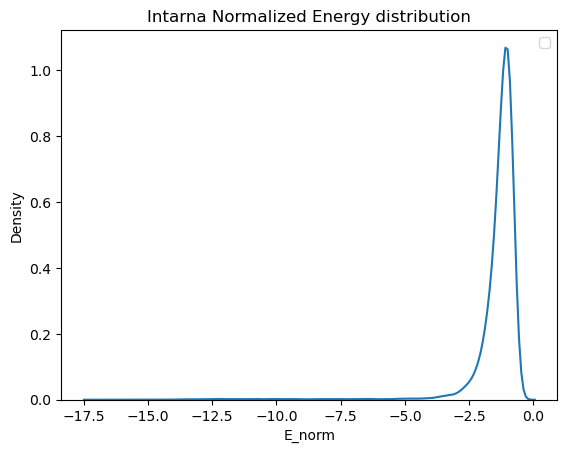

In [21]:
sns.kdeplot(easypos_smartneg.E_norm)
plt.title(f'Intarna Normalized Energy distribution')
plt.legend()
plt.show()

In [139]:
def plot_ROC_based_on_confidence(df, how = 'intarna', treshold = 0.05):
    if how == 'intarna':
        subset = df[
            (df.E_norm <= df.E_norm.quantile(treshold))|
            (df.E_norm >= df.E_norm.quantile(1-treshold))
        ]
    elif how == 'nt':
        subset = df[
            (df.probability <= treshold)|
            (df.probability >= (1-treshold))
        ]
    else:
        raise NotImplementedError
    print('perc of the total data: ', np.round(subset.shape[0]/df.shape[0], 3)*100, '%')
    plot_roc_curves([{'prob': subset.probability, 'model_name': 'NT'},
                 {'prob': abs(subset.E_norm), 'model_name': 'Intarna'}
                ], subset.ground_truth)

perc of the total data:  2.0 %


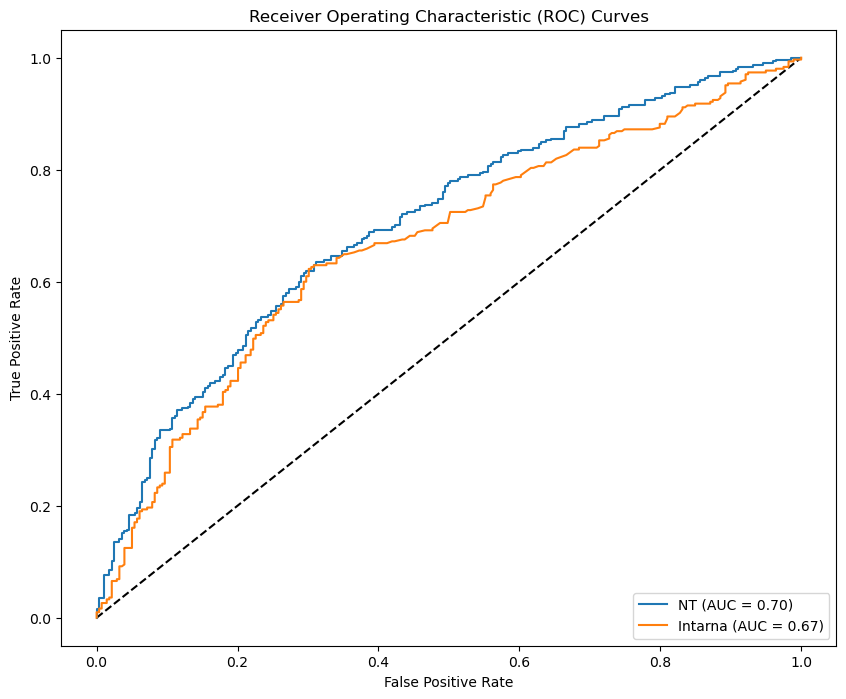

In [134]:
plot_ROC_based_on_confidence(easypos_smartneg, treshold = 0.01)

perc of the total data:  8.3 %


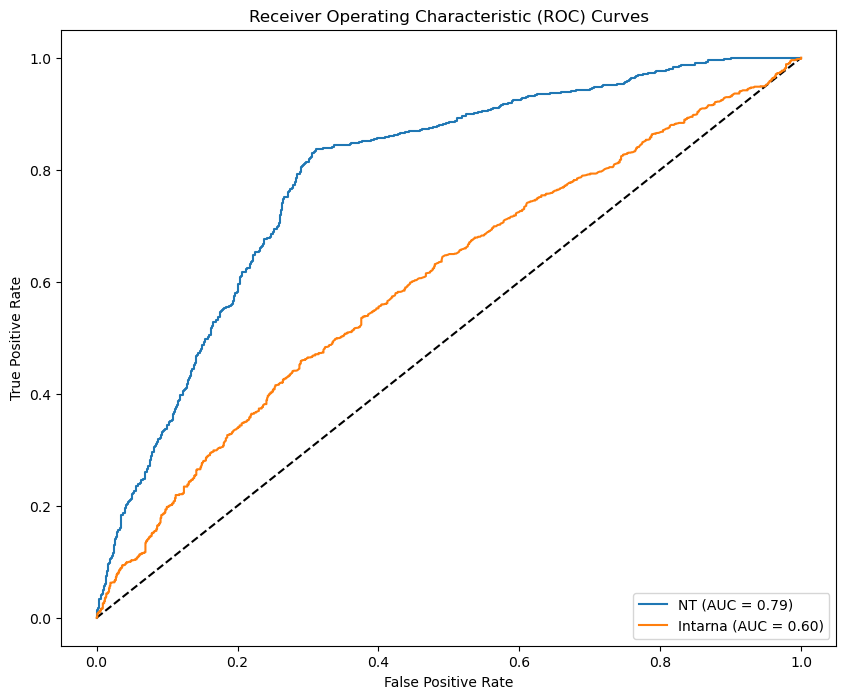

In [140]:
plot_ROC_based_on_confidence(easypos_smartneg, how = 'nt', treshold = 0.25)

In [127]:
def collect_results_based_on_confidence_level(df, how = 'intarna', n_values = 35):
    auc_nt = []
    auc_intarna = []
    confidence_level = []
    
    confidence_space = np.linspace(0.51, 0.99, n_values)
    for i in range(n_values):
        
        if how == 'intarna':
            treshold = 1-confidence_space[i]
            subset = df[
                (df.E_norm <= df.E_norm.quantile(treshold))|
                (df.E_norm >= df.E_norm.quantile(1-treshold))
            ]
        elif how == 'nt':
            treshold = confidence_space[i]
            subset = df[
                (df.probability >= treshold)|
                (df.probability <= (1-treshold))
            ]
        else:
            raise NotImplementedError
        
        if subset.shape[0]>0:
            fpr, tpr, _ = roc_curve(subset.ground_truth, subset.probability)
            roc_auc = auc(fpr, tpr)
            auc_nt.append(roc_auc)

            fpr, tpr, _ = roc_curve(abs(1 - subset.ground_truth), subset.E_norm)
            roc_auc = auc(fpr, tpr)
            auc_intarna.append(roc_auc)

            confidence_level.append(confidence_space[i])
        
    return confidence_level, auc_nt, auc_intarna

Text(0.5, 0, 'Confidence level')

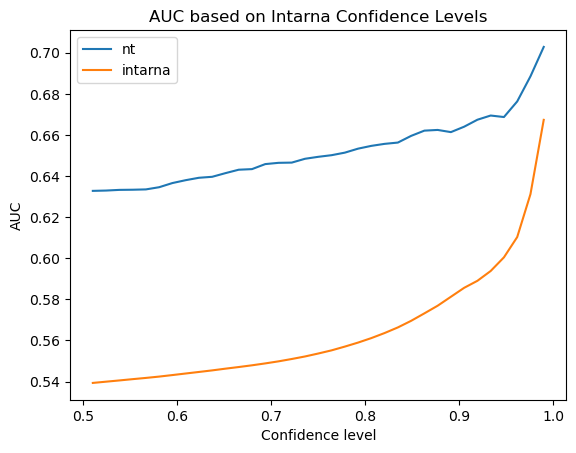

In [128]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'intarna')

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on Intarna Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel('Confidence level')

Text(0.5, 0, 'Confidence level')

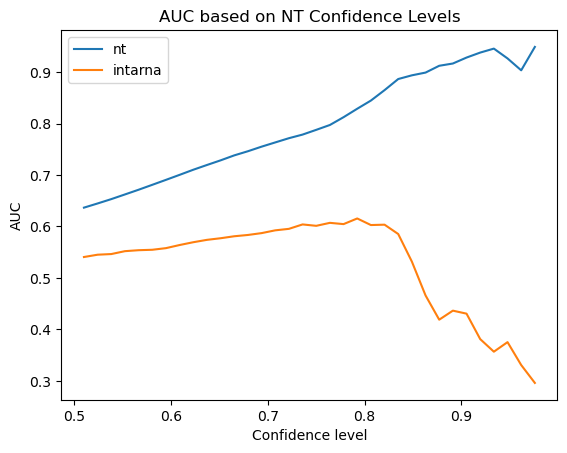

In [129]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'nt')

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on NT Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel('Confidence level')

In [239]:
treshold = 0.83
subset_where_disagree = easypos_smartneg[
                (easypos_smartneg.probability >= treshold)|
                (easypos_smartneg.probability <= (1-treshold))
            ]

In [241]:
subset_where_disagree.ground_truth.value_counts()

1    337
0    305
Name: ground_truth, dtype: int64

In [242]:
diff = df_nt[['couples_id', 'diff1', 'diff2']].dropna()
new_cols = diff.couples_id.str.extractall('(.*)_(.*)').reset_index()
diff['gene1'] = new_cols[0]
diff['gene2'] = new_cols[1]
diff = pd.concat([
    diff[['gene1', 'diff1']].rename({'gene1':'gene', 'diff1':'diff'}, axis = 1),
    diff[['gene2', 'diff2']].rename({'gene2':'gene', 'diff2':'diff'}, axis = 1)
], axis = 0)
gb = diff.groupby('gene').std()
assert gb[gb['diff'] >= 0.001].shape[0] == 0
diff = diff.drop_duplicates('gene')
diff['abs_diff'] = abs(diff['diff'])

In [243]:
subset_where_disagree = subset_where_disagree.merge(diff, how = 'left', left_on = 'gene1_original', right_on = 'gene').drop(['gene','abs_diff'] , axis = 1).rename({'diff':'diff1'}, axis = 1)
subset_where_disagree = subset_where_disagree.merge(diff, how = 'left', left_on = 'gene2_original', right_on = 'gene').drop(['gene','abs_diff'] , axis = 1).rename({'diff':'diff2'}, axis = 1)
subset_where_disagree['diff1'] = subset_where_disagree['diff1'].fillna(0)
subset_where_disagree['diff2'] = subset_where_disagree['diff2'].fillna(0)
subset_where_disagree['sum_diff'] = subset_where_disagree['diff1'] + subset_where_disagree['diff2']

In [250]:
quantile_level = 0.95

problematic_genes = set(diff[diff.abs_diff> diff.abs_diff.quantile(quantile_level)].gene)

print('the percentage of problematic genes is:', np.round(len(problematic_genes)/diff.shape[0] * 100, 2))

perc = subset_where_disagree[
    subset_where_disagree.gene1_original.isin(problematic_genes)|
    subset_where_disagree.gene2_original.isin(problematic_genes)
].shape[0]/subset_where_disagree.shape[0]

print('percentage of pairs belonging to problematic genes: ', np.round(perc*100, 2))

the percentage of problematic genes is: 4.99
percentage of pairs belonging to problematic genes:  68.54


In [268]:
perc = subset_where_disagree[
    ((subset_where_disagree['sum_diff'] >= 0) & (subset_where_disagree['prediction'] == 0))|
    ((subset_where_disagree['sum_diff'] <= 0) & (subset_where_disagree['prediction'] == 1))
].shape[0]/subset_where_disagree.shape[0]

print('The percentage of pairs where the model predicts the sum of the degrees is: ', np.round(perc*100, 2))

The percentage of pairs where the model predicts the sum of the degrees is:  78.19


# XAI

In [ ]:
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'))

DEVICE = 'cpu'

args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(checkpoint_dir, 'best_model_fine_tuning.pth') # best_model

device = torch.device(DEVICE)
model = build_model(args)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model.to(device)
model.eval()

def plot_query_results(query):
    for _, row in query.iterrows():
        x1_emb, x2_emb, y1_emb, y2_emb = int(np.round(row.x1/6)), int(np.round(row.x2/6)), int(np.round(row.y1/6)), int(np.round(row.y2/6))

        embedding1_path = os.path.join(embedding_dir, '32', row.gene1+'.npy')
        embedding2_path = os.path.join(embedding_dir, '32', row.gene2+'.npy')

        embedding1 = np.load(embedding1_path)[x1_emb:x2_emb, :]
        embedding2 = np.load(embedding2_path)[y1_emb:y2_emb, :]

        rna1, rna2 = torch.as_tensor(embedding1).unsqueeze(0), torch.as_tensor(embedding2).unsqueeze(0)
        rna1, rna2 = torch.transpose(rna1, 1, 2), torch.transpose(rna2, 1, 2)

        rna1, rna2 = rna1.to(device), rna2.to(device)

        outputs = model(rna1, rna2)

        outputs[:, 1].backward()
        print(outputs.softmax(-1)[:, 1])
        x1 = int(row.seed_x1-row.x1)
        x2 = int(row.seed_x2-row.x1)
        y1 = int(row.seed_y1-row.y1)
        y2 = int(row.seed_y2-row.y1)
        width = row.len1
        height = row.len2

        expl_matrix = gradcam(model, rna1, rna2, counterfactual = False, cnn_layer = 2)
        expl_matrix_reshaped = interpolate_expl_matrix(expl_matrix, height, width)

        scaling_factor = 70

        plot_matrix(expl_matrix_reshaped, 
        ''.join(['C'for i in range(width)]), 
        ''.join(['C'for i in range(height)]), 
        [[x1, y1, x2-x1, y2-y1]], #crop_bbox =[x1hat, y1hat, what, hhat], 
        cmap ='viridis', 
        scaling_factor = scaling_factor)
        plt.show()

In [44]:
xai = pd.read_csv(os.path.join(checkpoint_dir, 'gradcam_results500_finetuning.csv'))

In [45]:
xai = xai.merge(res.filter([
    'couples', 'gene1_pc', 'gene2_pc', 'original_length1', 'original_length2', 'id_sample', 'g1', 'g2', 'gene1_original', 'gene2_original'
], axis = 1), left_on = 'id', right_on = 'id_sample')

In [46]:
gradcam_results = xai[xai.probability>0.5]

iou_value: 0.0054
iou_value_tr: 0.0049
iou_value_rand: 0.0029


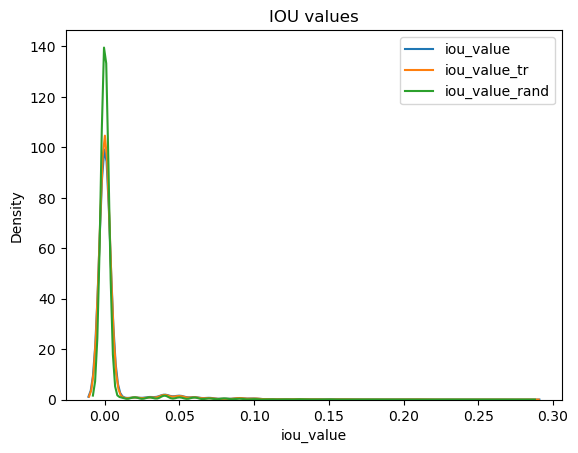

intensity: 0.3155
intensity_tr: 0.1121
intensity_rand: 0.5


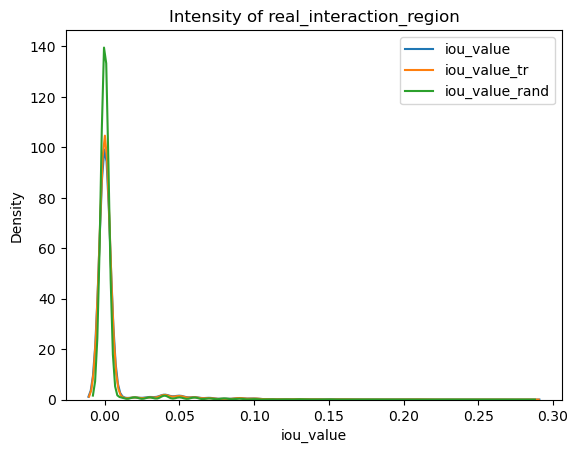

euclidean: 0.4796
euclidean_rand: 0.531
euclidean_bbox_tr: 0.5075


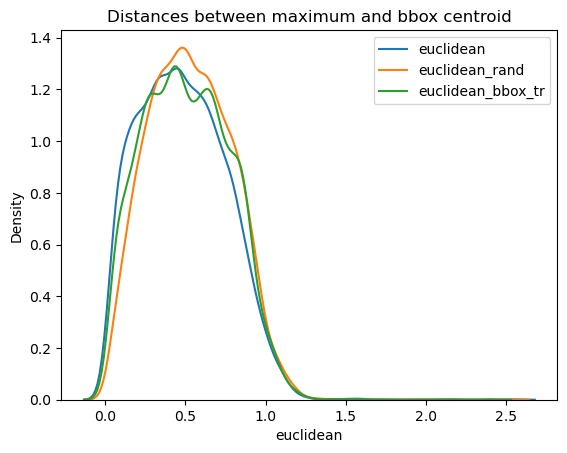

cos_sim: 0.05
cos_sim_tr: 0.04
cos_sim_rand: 0.04


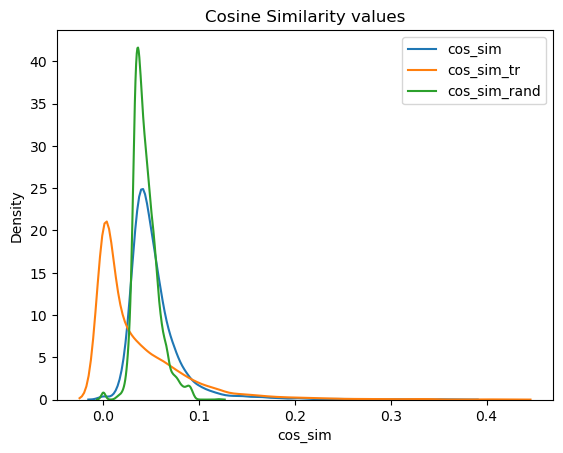

In [47]:
iou_columns = ['iou_value', 'iou_value_tr', 'iou_value_rand']
for c in iou_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'IOU values')
plt.legend()
plt.show()

intensity_columns = ['intensity', 'intensity_tr', 'intensity_rand']
for c in intensity_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
    
plt.title(f'Intensity of real_interaction_region')
plt.legend()
plt.show()

euclidean_columns = ['euclidean', 'euclidean_rand', 'euclidean_bbox_tr']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid')
plt.legend()
plt.show()

cosine_sim_columns = ['cos_sim', 'cos_sim_tr', 'cos_sim_rand']
for c in cosine_sim_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 2))}')

for c in cosine_sim_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Cosine Similarity values')
plt.legend()
plt.show()

#### Subset XAI results

In [48]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

/tmp/ipykernel_561004/2875514386.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))


euclidean: 0.352
euclidean_rand: 0.671


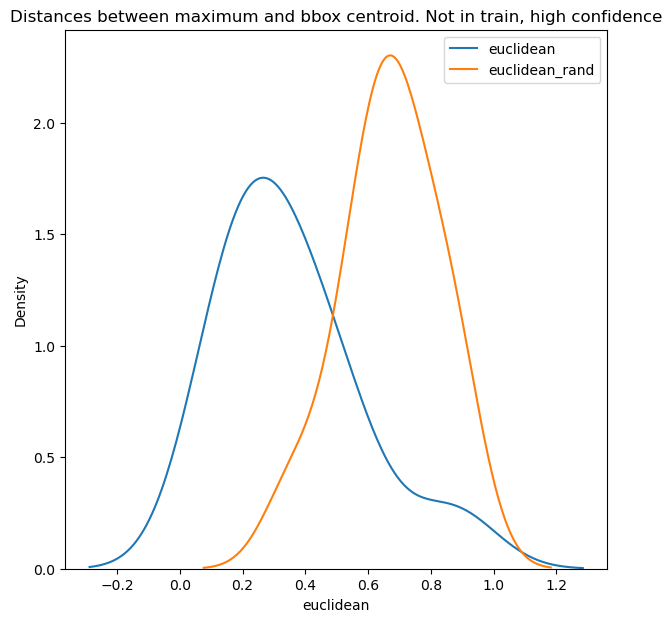

In [117]:
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.probability>0.65)&(gradcam_results.probability<0.8)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. Not in train, high confidence')
plt.legend()
plt.show()

tensor([0.7216], grad_fn=<SelectBackward0>)


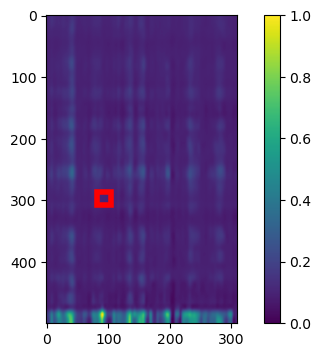

tensor([0.6987], grad_fn=<SelectBackward0>)


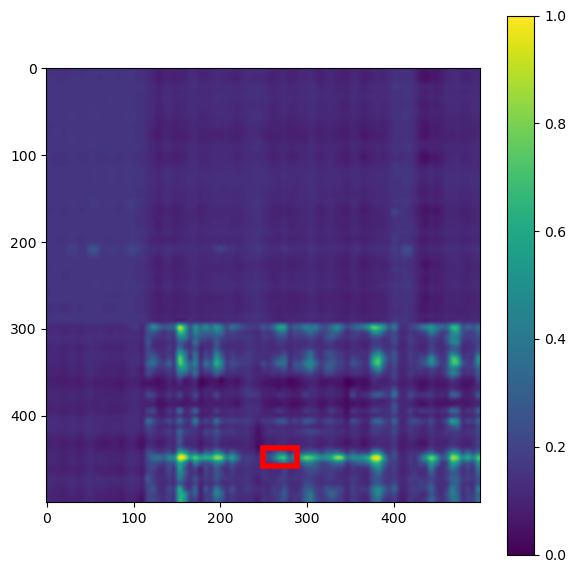

tensor([0.6878], grad_fn=<SelectBackward0>)


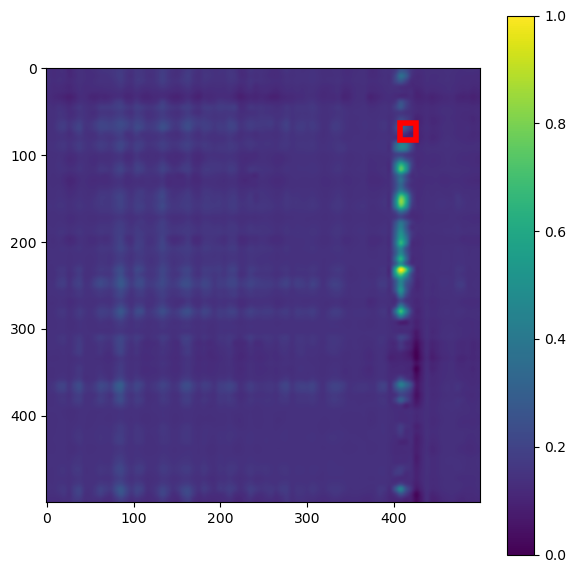

tensor([0.6520], grad_fn=<SelectBackward0>)


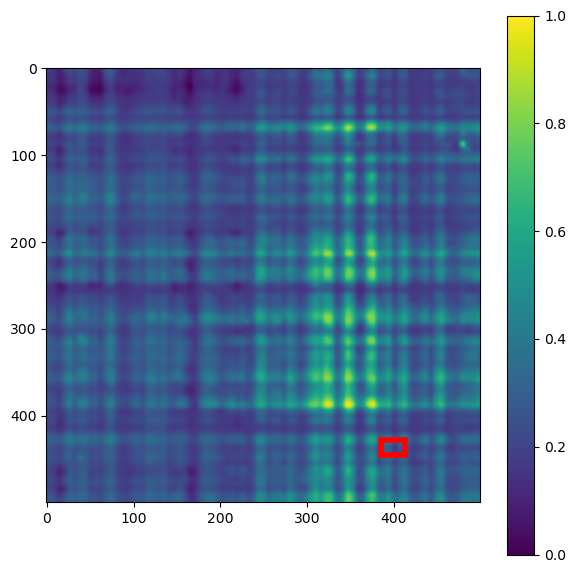

tensor([0.6913], grad_fn=<SelectBackward0>)


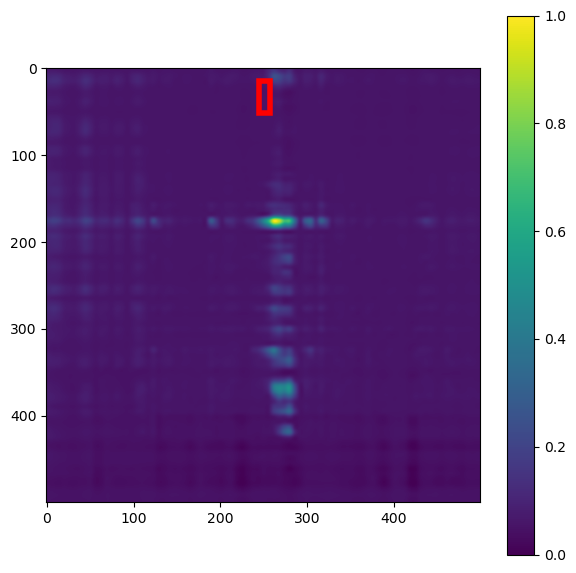

tensor([0.6579], grad_fn=<SelectBackward0>)


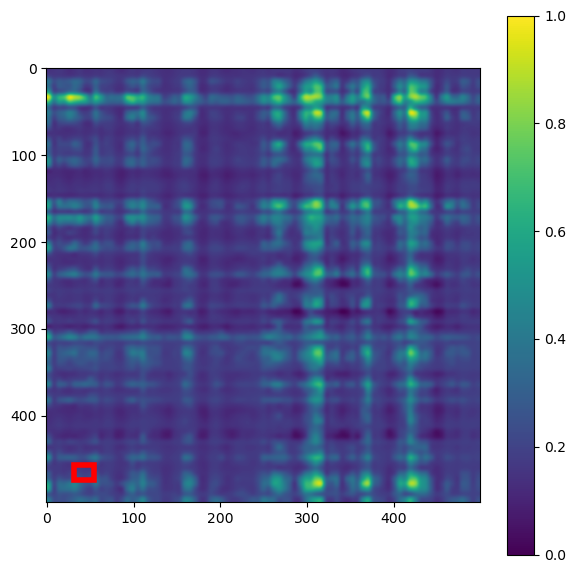

tensor([0.7839], grad_fn=<SelectBackward0>)


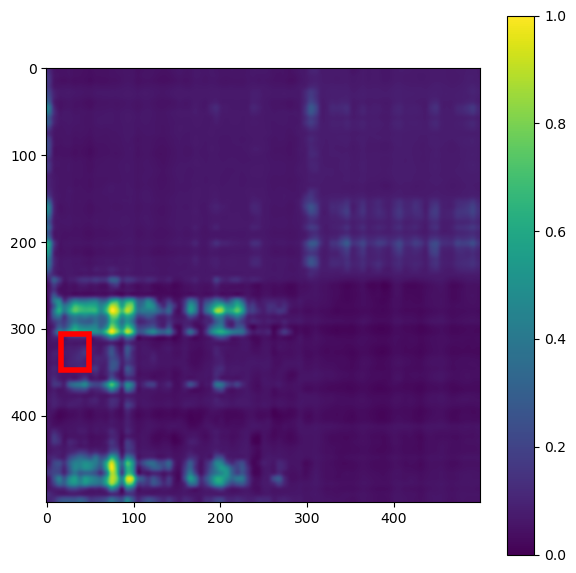

tensor([0.6573], grad_fn=<SelectBackward0>)


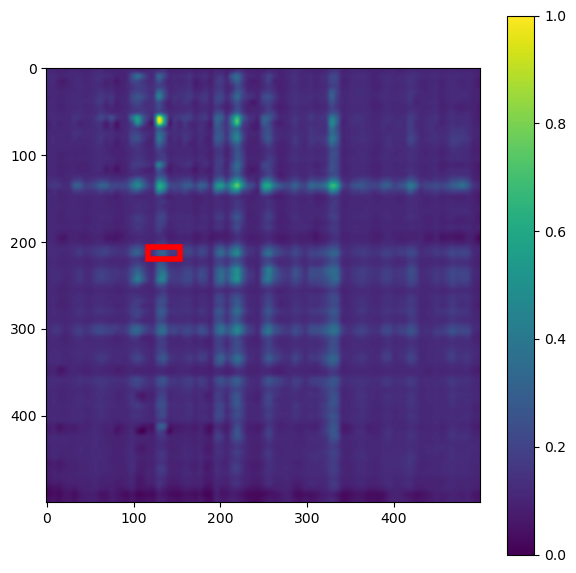

tensor([0.6803], grad_fn=<SelectBackward0>)


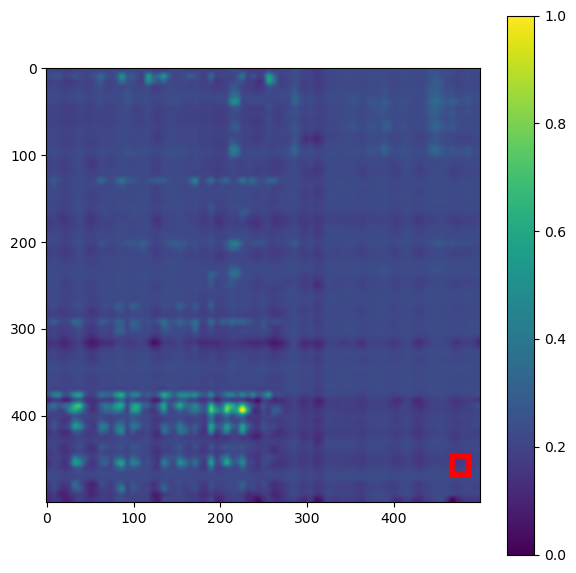

tensor([0.6780], grad_fn=<SelectBackward0>)


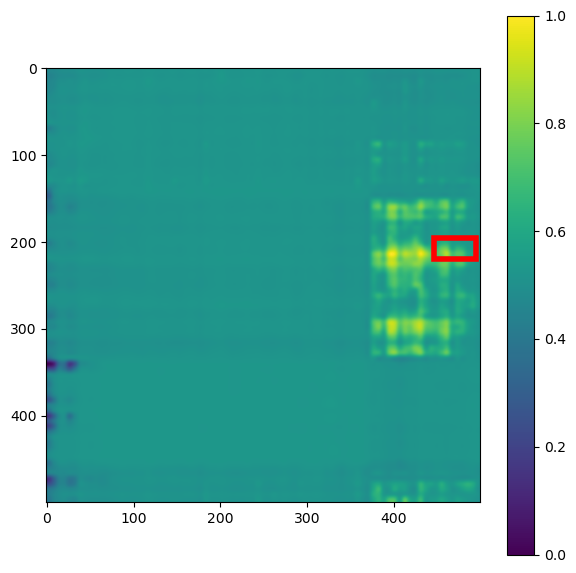

tensor([0.7255], grad_fn=<SelectBackward0>)


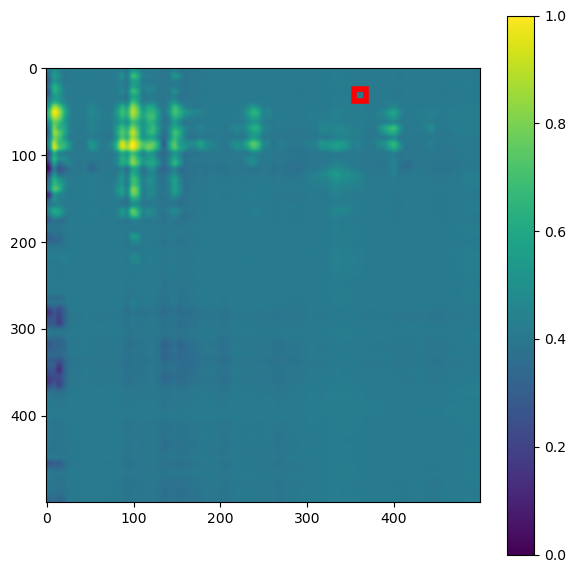

In [120]:
query = test500[test500.couples.isin(list(gradcam_results.id))]
plot_query_results(query)

euclidean: 0.4454
euclidean_rand: 0.5418


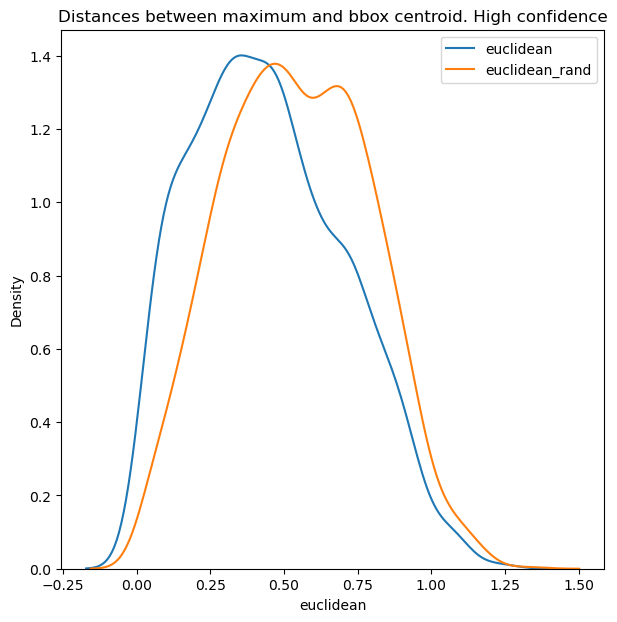

In [115]:
gradcam_results = xai[(xai.probability>0.65)&(xai.probability<0.8)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. High confidence')
plt.legend()
plt.show()